## Segment Anything Model ([SAM](https://github.com/facebookresearch/segment-anything)) 
- Promptable segmentation system with zero-shot generalization to unfamiliar objects and images.
- It can be fine-tuned to segment objects of interest in images based on a given set of prompts.
- The model is built using the Vision Transformer (ViT) architecture and can be adapted to various segmentation tasks with minimal training data.

## Links
- [github](https://github.com/facebookresearch/segment-anything)
- [segment-anything.com](https://github.com/facebookresearch/segment-anything)

## Training dataset:
- 11 million images
- 1.1 billion masks

***
## Import and install packages

In [2]:
%pip install -qqq git+https://github.com/facebookresearch/segment-anything.git

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from glob import glob

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from PIL import Image
import albumentations as A

import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision import transforms as T
# from torchvision.transforms import v2 as T

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

***
## Create custom Segmentation Dataset

In [4]:
"""Mask Dataset with torchvision transforms"""

class SegmetationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        
        self.image_files = sorted(glob(f"{self.root}/Image/*"))
        self.mask_files = sorted(glob(f"{self.root}/Mask/*"))
        self.total_ims = len(self.image_files)
        self.total_gts = len(self.mask_files)

        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')

    def __len__(self):
        return min(len(self.image_files), len(self.mask_files))

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # Load images using PIL
        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Define your custom transforms
custom_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

***
## Helper functions

In [50]:
def show_images_with_masks(dataset, indices=[0]):
    """
    Display a specified number of image-mask pairs from a Torch dataset.

    Args:
    - dataset: Torch dataset containing image-mask pairs (e.g., TensorDataset).
    - indices: list of image indices.
    """
    # Create a figure with multiple subplots
    img_number = len(indices)
    fig, axs = plt.subplots(img_number, 2, figsize=(7, 4 * img_number))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img = img.permute(1, 2, 0).numpy() # Convert to numpy image format (C, H, W) -> (H, W, C)
        if len(mask.shape) == 3:
            mask = mask.permute(1,2,0).numpy()
        else:
            mask = mask.numpy()

        # Display the image
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')

        # Display the mask
        axs[i, 1].imshow(mask)
        axs[i, 1].set_title('Mask')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
def show_anns(anns, axes=None):
    """
    Process and plot detected masks on image.
    
    Args:
    - anns: SAM mask generator output
    """
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
        
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))
        
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([230/255, 245/255, 15/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

***
## Create DS & Visu

In [6]:
# Create the dataset
root_folder = '/kaggle/input/flood-area-segmentation'
custom_dataset = SegmetationDataset(root_folder, transform=custom_transforms)

# Example
sample_idx = 1
image, mask = custom_dataset[sample_idx]

There are 290 images and 290 masks in the dataset


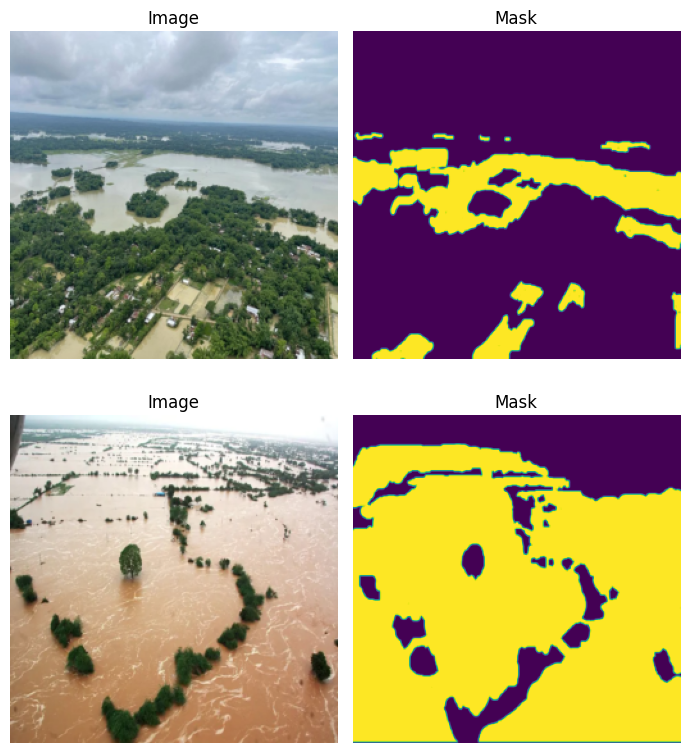

In [7]:
# Randomly select samples from the dataset

indices = torch.randperm(len(custom_dataset))[:2]
show_images_with_masks(custom_dataset, indices)

***
## Load SAM model, create Automatic mask generator

In [11]:
sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam,
                                           points_per_side=32,
                                           pred_iou_thresh=0.86,
                                           stability_score_thresh=0.92,
                                           crop_n_layers=1,
                                           crop_n_points_downscale_factor=2,
                                           min_mask_region_area=100, 
                                          )

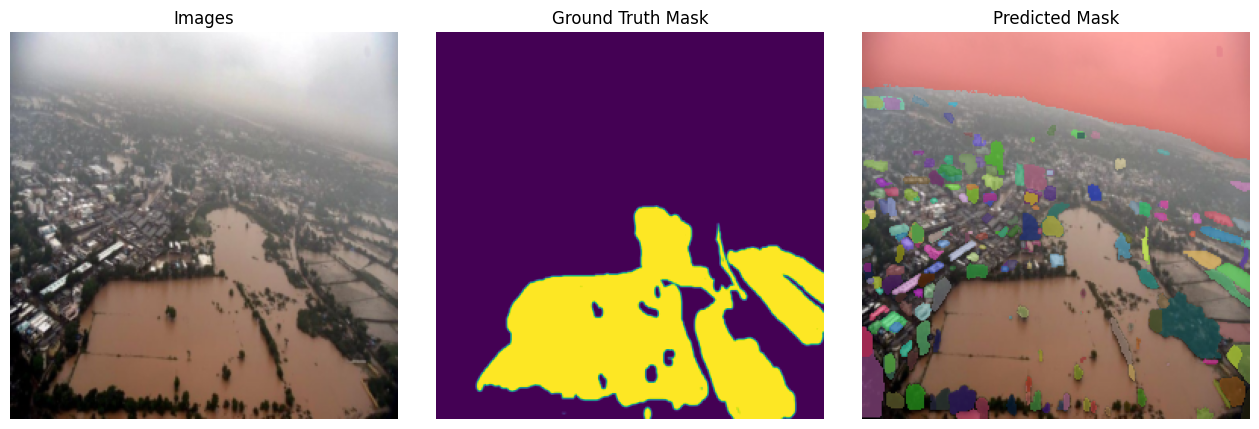

In [42]:
imgs, masks = custom_dataset[17]
imgs, masks = imgs.to(device),masks.to(device)

image = imgs.cpu().permute(1, 2, 0).numpy()

# Scale the image to the range of 0-255
uint8_image = (image * 255).astype(np.uint8)
predict_mask = mask_generator.generate(uint8_image)

# Plot the original image and the mask
fig, axs = plt.subplots(1, 3, figsize=(16, 16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

axs[0].imshow(image)

# axs[1].imshow(masks.cpu().numpy())
axs[1].imshow(np.transpose(masks.cpu().numpy(),(1,2,0)))

axs[2].imshow(image)
show_anns(predict_mask)

axs[0].set_title("Images");
axs[1].set_title("Ground Truth Mask");
axs[2].set_title("Predicted Mask");

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

## Generate masks with prompts

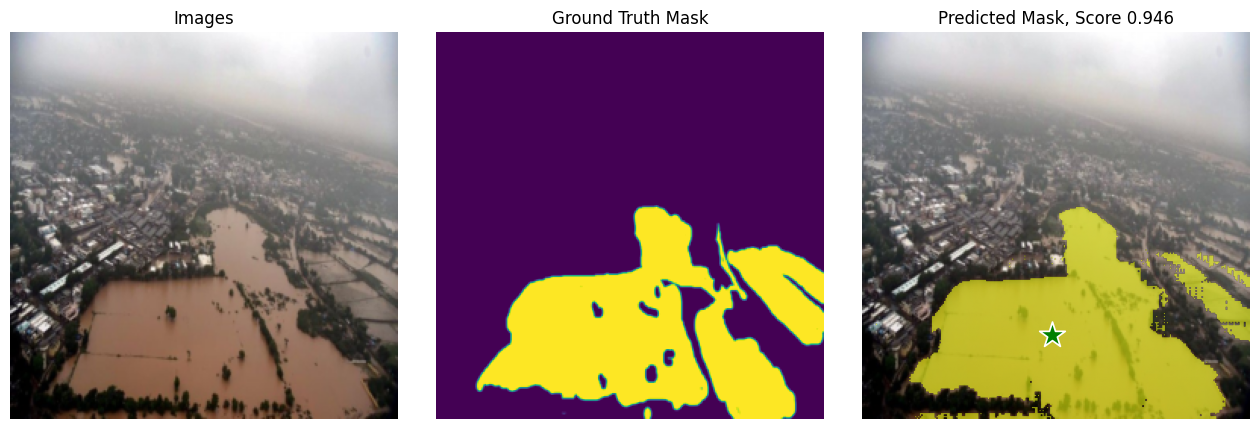

In [51]:
imgs, masks = custom_dataset[17] #17
imgs, masks = imgs.to(device),masks.to(device)

image = imgs.cpu().permute(1, 2, 0).numpy()

# Scale the image to the range of 0-255
uint8_image = (image * 255).astype(np.uint8)

# make predictions
predictor.set_image(uint8_image)

input_point = np.array([[125, 200]])
input_label = np.array([1])

pred_masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# import pdb; pdb.set_trace()

# Plot the original image and the mask
fig, axs = plt.subplots(1, 3, figsize=(16, 16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

axs[0].imshow(image)

axs[1].imshow(np.transpose(masks.cpu().numpy(),(1,2,0)))

# plot point and first mask
axs[2].imshow(image)
show_mask(pred_masks[0],axs[2])
show_points(input_point, input_label, axs[2])

axs[0].set_title("Images");
axs[1].set_title("Ground Truth Mask");
axs[2].set_title(f"Predicted Mask, Score {scores[0]:.3f}");

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

In [ ]:
"""
Ideas: 
    - fine tune it
    - text prompts (GroundingDINO -> bboxes)?
"""